In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from skimage.measure import block_reduce


import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,Compose

# Data Loading: X -> Low SNR, y -> high SNR as matched in dataset_generator.py

In [2]:
def load_dataset(path):
    with np.load(path,allow_pickle=True) as data:
        X_train = data["X_train"]
        y_train = data["y_train"]
        X_test = data["X_test"]
        y_test = data["y_test"]
    return X_train,y_train,X_test,y_test


# general image in k-space handling function

In [3]:
def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

def do_image(kspace):
    
    kspace=block_reduce(kspace, block_size=(1, 1,1, 2), func=np.mean)
    image = ifftnd(kspace, [-1,-2])
    image = rms_comb(image)
    
    

    return image



# Plot a pair (k/im) from dataset

In [4]:
def plot_pair(vol,fetta=12):
    im_GT = do_image(y_test[vol,:,:,:,:])
    im = do_image(X_test[vol,:,:,:,:])
    f,axes=plt.subplots(1,2,figsize=(12,12))
    axes[0].imshow(im[fetta,:])
    axes[1].imshow(im_GT[fetta,:])

# Normalization in K and Image space
## change this to act on pre processing normalizzation of data

In [5]:
def normalize_image(vol):
    vol=(vol-vol.min())/(vol.max()-vol.min())
    
    return vol

def normalize_kspace(vol):
    norm = np.abs(vol).max()
    return vol/norm

def norm_dataset(vol):
    normed=np.apply_along_axis(normalize_kspace, 0, vol)
    return normed
    


# Standard Data generator: it loads an image, the reference image and apply custom transformazion in order

In [6]:
class proton_dataset(Dataset):
    def __init__(self, X, y, transform=None):
        
        s=X.shape
        X.shape == y.shape
        
        self.X = X.reshape((-1,s[2],s[3],s[4]))
        self.y = y.reshape((-1,s[2],s[3],s[4]))
        self.trans=transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        image = self.X[idx]
        label = self.y[idx]
        
        if self.trans:
            image = self.trans(image)
            label = self.trans(label)
       
        return image, label

# Data transformation and augmentation: work in progress

In [7]:
class ToTensor_torch(nn.Module):

    def __init__(self):
        super().__init__()
        
    def forward(self, x) -> torch.Tensor:
        with torch.no_grad():
            image = torch.from_numpy(x)
            image_cat = torch.cat((image.real,image.imag),dim=0)
            return image_cat


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # from numpy to tensor with channel stacked
        
        
        image = torch.from_numpy(image)
        image_cat = torch.cat((image.real,image.imag),dim=0)
        return image_cat

class AddNoise_torch(nn.Module):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, noise_std):
        super().__init__()
        self.noise_std=noise_std
        
    def forward(self, image):
        # noise added 
        with torch.no_grad():
            image = image + self.noise_std*image.std()*torch.randn(image.shape,dtype=image.dtype)
        
        return image

    
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    k_batch, k_label_batch = sample_batched[0], sample_batched[1]
    
    images_batch = do_image(k_batch)  
    label_batch = do_image(k_label_batch) 
    
    
    batch_size = len(images_batch)
    print(batch_size)
    if batch_size > 8:
        batch_size = 8
    im_size = images_batch.shape[2:3]
    

    f,axes = plt.subplots(batch_size,2,figsize=(15,30))
    for i in range(batch_size):
        axes[i,0].imshow(images_batch[i])
        axes[i,0].set_title("Low SNR")
        axes[i,1].imshow(label_batch[i])
        axes[i,1].set_title("high SNR")
        axes[i,0].axis('off')
        #axes[i,0].ioff()
        axes[i,1].axis('off')
        #axes[i,1].ioff()

#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model_run2.pth')

In [8]:
class FreqToSpace(nn.Module):

    def __init__(self):
        super().__init__()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            z = torch.complex(x[:,0,:,:], x[:,1,:,:])#f2s
            im = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(z),dim=[-1,-2]),dim=[-1,-2])
            im = torch.unsqueeze(im,dim=1)
            im = torch.cat((im.real,im.imag),dim=1)
            
            return im
        
        
class SpaceToFreq(nn.Module):

    def __init__(self):
        super().__init__()
    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = torch.complex(x[:,0,:,:], x[:,1,:,:])
            z = torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(x),dim=[-1,-2]),dim=[-1,-2])
            z = torch.unsqueeze(z,dim=1)
            z = torch.cat((z.real,z.imag),dim=1)
            return z

In [9]:
X_train,y_train,X_test,y_test = load_dataset("/workspace/data/proton_data_train_test.npz")

NORMALIZE=True
if NORMALIZE:
    X_train = norm_dataset(X_train)
    y_train = norm_dataset(y_train)
    X_test = norm_dataset(X_test)
    y_test = norm_dataset(y_test)

In [10]:
# to M space
# transform
# back

import torchvision.transforms as T

transforms = nn.Sequential(# questo lo ripasso a sequential
    
    FreqToSpace(),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.3),
    T.RandomRotation(10),
    T.RandomResizedCrop((80,256),scale=(0.8, 1.0),interpolation = T.functional.InterpolationMode.NEAREST),
    SpaceToFreq(),
    AddNoise_torch(0.05)
    #FreqToSpace()
)



fts = FreqToSpace()
asd=fts(sample[1])
asd2 =transforms(sample[1])
plt.figure()
plt.imshow(asd.abs().numpy()[23,0,:,:])
plt.figure()
plt.imshow(asd2.abs().numpy()[23,0,:,:])

# Actual code:
 - Load data
 - Normalize it (volume normalization)
 - Define custom transformation
 - Model definition
 

# Array of transformation to be applied

In [32]:
composed_train = Compose([ ToTensor(),transforms])
composed_test = Compose([ ToTensor()])


In [33]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [34]:

# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 16}
max_epochs = 100

# Data generator and plotter utility

In [35]:
# Generators
training_set = proton_dataset(X_train, y_train,composed_train)
training_generator = DataLoader(training_set, **params)

test_set = proton_dataset(X_test, y_test,composed_test)
test_generator = DataLoader(test_set, **params)

In [36]:

sample = next(iter(training_generator))

show_landmarks_batch(sample)


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-6-b7c3431ee244>", line 20, in __getitem__
    image = self.trans(image)
  File "/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 60, in __call__
    img = t(img)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1015, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py", line 118, in forward
    input = module(input)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1015, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-8-85d0808da266>", line 8, in forward
    z = torch.complex(x[:,0,:,:], x[:,1,:,:])#f2s
IndexError: too many indices for tensor of dimension 3


In [16]:
sample[0].shape

torch.Size([128, 2, 80, 256])

In [17]:
diff=np.abs(sample[0]-sample[1]).numpy()

In [18]:
diff.shape

(128, 2, 80, 256)

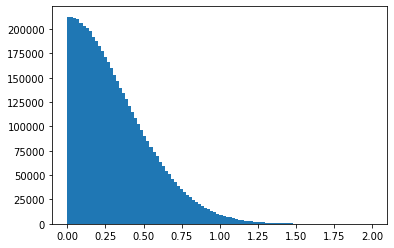

In [19]:
_=plt.hist(diff.ravel(),100)

# Model Definition: 

In [20]:
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=12):
        super(DnCNN, self).__init__()
        kernel_size = [3,7]
        padding = [1,3]
        features = 32
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        
        self.subs= torch.nn.AvgPool2d([1,2])
        
    def forward(self, x):
        out = x - self.dncnn(x)
        subs = self.subs(out)
        
        z = torch.complex(subs[:,0,:,:], subs[:,1,:,:])
        im = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(z),dim=[-1,-2]),dim=[-1,-2]).abs()
        
        return out, im
    
    
    

# Mixed Loss definition:
 - both kspace difference and magnitude image are computed in loss.

In [21]:
class MixedLoss(nn.Module):
    def __init__(self, beta=0.1, weight=None, size_average=True):
        super(MixedLoss, self).__init__()
        
        self.pool2D=torch.nn.AvgPool2d([1,2])
        self.MSEloss = nn.MSELoss()
        self.beta=0.1
 
    def forward(self, k_pred,im_pred, targets):     
        
        z = self.pool2D(targets)# subsample
        z = torch.complex(z[:,0,:,:], z[:,1,:,:])# to complex
        im = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(z),dim=[-1,-2]),dim=[-1,-2]).abs()#to imaspace
        
        im=torch.nn.functional.normalize(im, p=2.0, dim=[0])# normalized GT image
        im_pred=torch.nn.functional.normalize(im_pred, p=2.0, dim=[0])# normalized prediction
        
        im_loss = self.MSEloss(im,im_pred)
        
        k_loss = self.MSEloss(k_pred,targets)
        
        return k_loss + self.beta*im_loss

In [22]:
model = DnCNN(2)
# move the model into the GPU
model.to('cpu')
print('The model is in the: ', next(model.parameters()).device)
model.to(device)
print('now the model is in the: ', next(model.parameters()).device)

The model is in the:  cpu
now the model is in the:  cuda:0


In [23]:
#!pip install torchsummary

In [24]:
from torchsummary import summary
if torch.cuda.is_available():
    summary(model.cuda(), input_size=(2,80,256))
else:
    summary(model, input_size=(2,80,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 80, 256]           1,344
              ReLU-2          [-1, 32, 80, 256]               0
            Conv2d-3          [-1, 32, 80, 256]          21,504
       BatchNorm2d-4          [-1, 32, 80, 256]              64
              ReLU-5          [-1, 32, 80, 256]               0
            Conv2d-6          [-1, 32, 80, 256]          21,504
       BatchNorm2d-7          [-1, 32, 80, 256]              64
              ReLU-8          [-1, 32, 80, 256]               0
            Conv2d-9          [-1, 32, 80, 256]          21,504
      BatchNorm2d-10          [-1, 32, 80, 256]              64
             ReLU-11          [-1, 32, 80, 256]               0
           Conv2d-12          [-1, 32, 80, 256]          21,504
      BatchNorm2d-13          [-1, 32, 80, 256]              64
             ReLU-14          [-1, 32, 

In [25]:
loss_func = MixedLoss(beta=0.1) #binary cross entropy loss
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-4)

In [26]:


metric_func = nn.MSELoss()


In [27]:
#training loop
TRAIN=False
model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
model.to(device)
if TRAIN:
    import time

    save_best_model = SaveBestModel()

    # lists to save loss and metric history
    hist_loss = []
    hist_metric = []
    hist_vloss = []
    hist_vmetric = []

    #loop over epochs
    for epoch in range(max_epochs):
        t0 = time.time()

        #training step
        model.train()

        train_loss = 0.0
        train_metric = 0.0
        counter = 0
        for xb, yb in training_generator: #takes a batch from the train dataloader 
            counter += 1 
            xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
            yb=yb.type(torch.float).to(device)

            pred_k,pred_im = model(xb) #get prediction for batch
            loss = loss_func(pred_k,pred_im, yb) #compute loss
            metric = metric_func(pred_k, yb) #compute metric

            train_loss += loss.item() #update total loss
            train_metric += metric.item() #update total metric

            # backpropagation
            loss.backward()
            # update weights
            opt.step()
            # set to zero gradients for the next step
            opt.zero_grad()

        # normalize loss and metric by number of batches
        train_loss = train_loss/counter
        train_metric = train_metric/counter

        # update history
        hist_loss.append(train_loss)
        hist_metric.append(train_metric)


        # evaluation setp (same as trainign but w/o backpropagation)
        model.eval()

        vali_loss = 0.0
        vali_metric = 0.0
        counter = 0
        with torch.no_grad():
            for xb, yb in test_generator:
                counter += 1
                xb=xb.type(torch.float).to(device)
                yb=yb.type(torch.float).to(device)
                pred_k,pred_im = model(xb)
                vloss = loss_func(pred_k,pred_im, yb)
                vmetric = metric_func(pred_k, yb)
                vali_loss += vloss.item()
                vali_metric += vmetric.item()

        vali_loss = vali_loss/counter
        vali_metric = vali_metric/counter    

        hist_vloss.append(vali_loss)
        hist_vmetric.append(vali_metric)

        #save best model
        save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

        elapsed_time = time.time()-t0
        print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

        # update learning rate schedule
        #scheduler.step()
    plt.figure(figsize=(10, 7))
    plt.subplot(1,2,1)
    plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
    plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
    plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.savefig("training.jpg")
else:
    model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
    model.eval()

In [28]:

model.load_state_dict(torch.load('best_model_run2.pth')['model_state_dict'])
model.eval()

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(2, 32, kernel_size=[3, 7], stride=(1, 1), padding=[1, 3], bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=[1, 3], bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=[1, 3], bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=[1, 3], bias=False)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=[1, 3], bias=False)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(32, 32, kernel_size

In [29]:
test_sample,test_label = next(iter(test_generator))
model.to('cpu')
pred = model(test_sample)


In [30]:
def show_pred_batch(sample_batched,pred):
    """Show image with landmarks for a batch of samples."""
    k_batch, k_label_batch = sample_batched[0], sample_batched[1]
    
    images_batch = do_image(k_batch)  
    label_batch = do_image(k_label_batch) 
    
    
    
    pred_image = do_image(pred[0].detach().numpy())
    
    out_image = pred[1].detach().numpy()
    
    
    batch_size = len(images_batch)
    print(batch_size)
    if batch_size > 8:
        batch_size = 8
    im_size = images_batch.shape[2:3]
    

    f,axes = plt.subplots(batch_size,4,figsize=(12,16))
    axes[0,0].set_title("low SNR")
    axes[0,1].set_title("High SNR")
    axes[0,2].set_title("K space predicted and transformed")
    axes[0,3].set_title("Direct Network predictcion")
    
    for i in range(batch_size):
        axes[i,0].imshow(images_batch[i])
        axes[i,1].imshow(label_batch[i])
        
        axes[i,2].imshow(pred_image[i])
        axes[i,3].imshow(out_image[i])
        
        
        axes[i,0].axis('off')
        #axes[i,0].ioff()
        axes[i,1].axis('off')
        axes[i,2].axis('off')
        axes[i,3].axis('off')
        #axes[i,1].ioff()

128


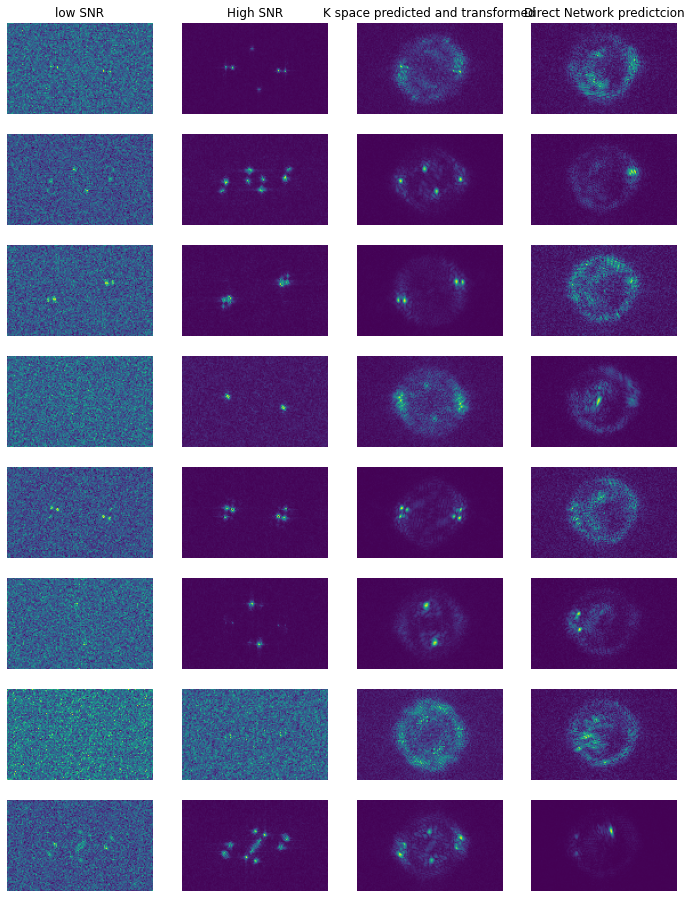

In [31]:
show_pred_batch([test_sample,test_label],pred)